# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
pip install phik

     |████████████████████████████████| 686 kB 2.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn --upgrade

     |████████████████████████████████| 13.4 MB 2.6 MB/s eta 0:00:01    |█████▎                          | 2.2 MB 2.6 MB/s eta 0:00:05     |██████████████                  | 5.8 MB 2.6 MB/s eta 0:00:03
     |████████████████████████████████| 301 kB 85.3 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import time
import phik
import lightgbm as lgb

In [4]:
data =  pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Приведём столбцы DateCrawled, DateCreated, LastSeen к формату datetime64

In [7]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

Изучим целевой столбец Price.

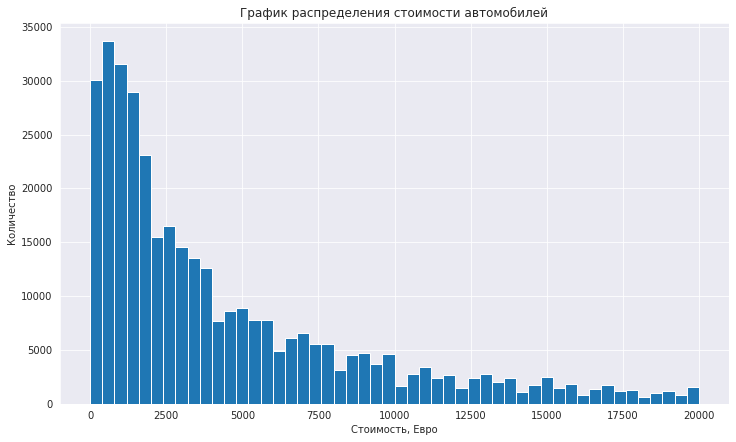

In [8]:
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость, Евро')
plt.ylabel('Количество')
plt.show()

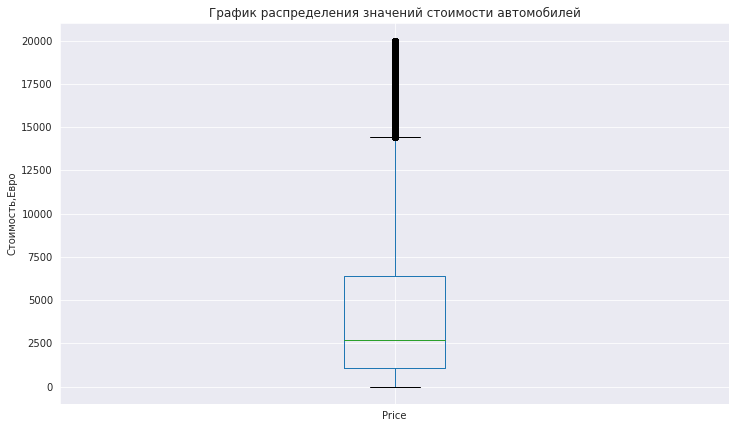

In [9]:
data.boxplot(['Price'],figsize=(12,7))
plt.title('График распределения значений стоимости автомобилей')

plt.ylabel('Стоимость,Евро')
plt.show()

Удалим данные об автомобилях, стоимость которых указана ниже 50 евро. Такие значения могут быть указаны, если продавец отдает сломанный автомобиль или планирует равноценный обмен. 

In [10]:
data = data.query('Price > 500')

In [11]:
data.loc[data['Price'] < 500]['Price'].count()

0

Проверим пропуски

In [12]:
data.VehicleType.isna().sum()

26225

In [13]:
data.DateCrawled.isna().sum()

0

In [14]:
data.RegistrationYear.isna().sum()

0

In [15]:
data.Gearbox.isna().sum()

12881

In [16]:
data.Power.isna().sum()

0

In [17]:
data.Model.isna().sum()

14226

In [18]:
data.Kilometer.isna().sum()

0

In [19]:
data.RegistrationMonth.isna().sum()

0

In [20]:
data.FuelType.isna().sum()

22522

In [21]:
data.Brand.isna().sum()

0

In [22]:
data.DateCreated.isna().sum()

0

In [23]:
data.NumberOfPictures.isna().sum()

0

In [24]:
data.PostalCode.isna().sum()

0

In [25]:
data.LastSeen.isna().sum()

0

Заполним пропуски.

In [26]:
data['VehicleType']=data['VehicleType'].fillna('N/A')

In [27]:
data.VehicleType.isna().sum()

0

In [28]:
data['FuelType']=data['FuelType'].fillna('other')

In [29]:
data.FuelType.isna().sum()

0

In [30]:
data.dropna(subset=['Gearbox'], inplace=True)

In [31]:
data.Gearbox.isna().sum()

0

In [32]:
data.dropna(subset=['Model'], inplace=True)

In [33]:
data.Model.isna().sum()

0

Проверим столбец RegistrationYear

In [34]:
data.RegistrationYear.unique()

array([2004, 2001, 2008, 1995, 2014, 1998, 2005, 2011, 2007, 2009, 2002,
       2018, 2017, 1981, 2003, 2016, 1991, 1984, 2006, 1999, 2012, 2010,
       2000, 1992, 1993, 1997, 2013, 1994, 1996, 1990, 1989, 2015, 1985,
       1982, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1986, 1965, 1970,
       1945, 1974, 1955, 1978, 1976, 1979, 1972, 1977, 1966, 1975, 1968,
       1963, 1967, 1960, 1500, 1964, 1910, 2019, 1937, 1951, 1953, 1954,
       1959, 1958, 1956, 2900, 5911, 1962, 1400, 1961, 4000, 1932, 1952,
       1950, 3700, 5000, 1942, 1957, 1923, 1930, 1929, 1943, 1938, 1934,
       1935, 1936, 1000, 6000, 1928, 1931, 4500, 1927, 7100, 1933, 1947,
       1600])

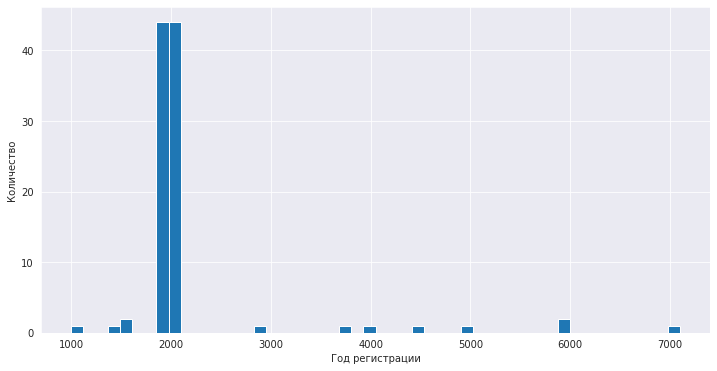

In [35]:
pd.Series(list(data.RegistrationYear.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), 
                                                                                  grid=True, bins=50)
plt.xlabel('Год регистрации')
plt.ylabel('Количество')
plt.show()

Удалим данные о совсем старых автомобилях, которым более 100 лет.

In [36]:
data.DateCrawled.max()

Timestamp('2016-04-07 14:36:58')

In [37]:
data=data.query('RegistrationYear >= 1924 & RegistrationYear <= 2016')

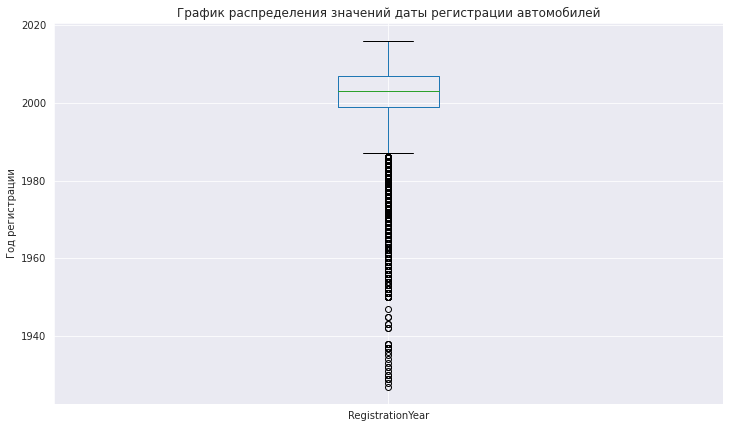

In [38]:
data.boxplot('RegistrationYear', figsize=(12,7))
plt.title('График распределения значений даты регистрации автомобилей')
plt.ylabel('Год регистрации')
plt.show()

In [39]:
data.RegistrationMonth.value_counts()

3     28677
6     25919
4     24127
5     24070
7     22562
10    21993
12    20163
9     20137
11    20133
1     18847
8     18810
2     17510
0     14653
Name: RegistrationMonth, dtype: int64

Заменим нулевые значения на среднее значение.

In [40]:
data.loc[data['RegistrationMonth'] == 0,'RegistrationMonth'] = 6

In [41]:
data.loc[data['RegistrationMonth'] == 6].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,6,other,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
18,2016-03-23 15:48:05,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no,2016-03-23,0,88361,2016-04-05 18:45:11
31,2016-03-29 16:57:02,899,N/A,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,6,other,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09


In [42]:
data.RegistrationMonth.unique()

array([ 8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9,  5])

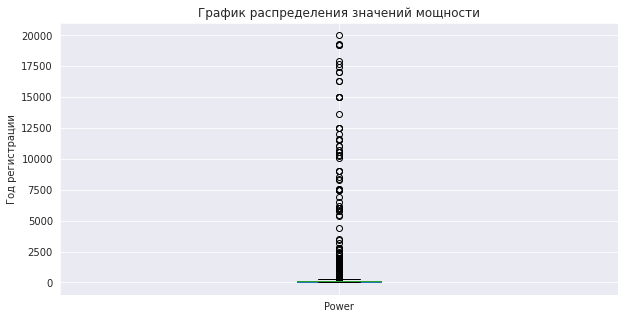

In [43]:
data.boxplot('Power', figsize=(10,5))
plt.title('График распределения значений мощности')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

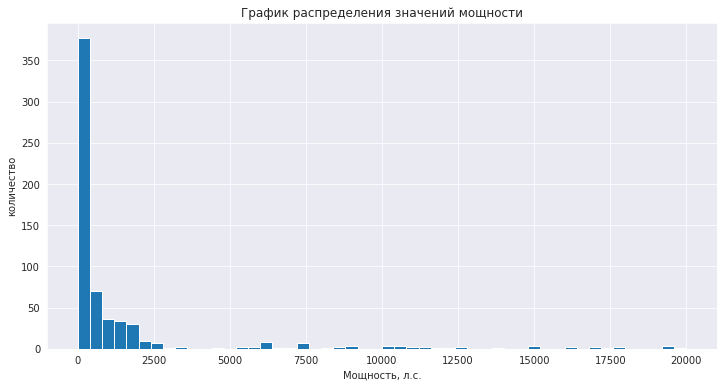

In [44]:
pd.Series(list(data.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения значений мощности')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
plt.show()

In [45]:
data.Power.describe()

count    277601.000000
mean        119.896881
std         182.342865
min           0.000000
25%          75.000000
50%         110.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

Удалим данные о мощности дигателя свыше 2500 л.с. и менее 15 л.с.

In [46]:
data=data.query('Power > 15 & Power < 2500')

In [47]:
data.Brand.unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'honda', 'fiat', 'opel',
       'mini', 'smart', 'hyundai', 'audi', 'subaru', 'volvo',
       'mitsubishi', 'alfa_romeo', 'kia', 'seat', 'suzuki', 'lancia',
       'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'jaguar', 'daewoo', 'rover', 'porsche', 'saab', 'land_rover',
       'trabant', 'lada'], dtype=object)

In [48]:
data.Repaired.unique()

array([nan, 'no', 'yes'], dtype=object)

In [49]:
data.Repaired.isna().sum()

31371

In [50]:
data['Repaired']=data['Repaired'].fillna('N/A')

In [51]:
data.Repaired.unique()

array(['N/A', 'no', 'yes'], dtype=object)

In [52]:
data.NumberOfPictures.describe()

count    261684.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

In [53]:
data=data.drop(['NumberOfPictures'], axis=1)

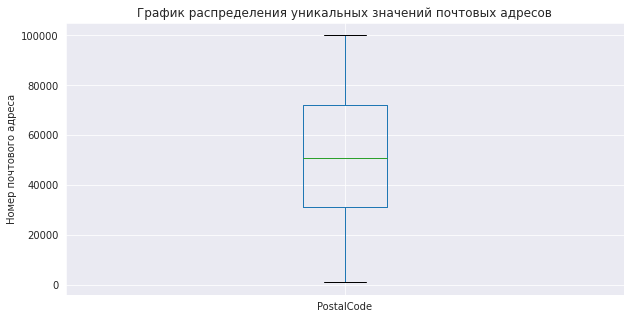

In [54]:
data.boxplot('PostalCode', figsize=(10,5))
plt.title('График распределения уникальных значений почтовых адресов')
plt.ylabel('Номер почтового адреса')
plt.xlabel('')
plt.show()

Чтобы избежать большого количества категорий, оставим от индекса только первую цифру.

In [55]:
data["PostalCode"]=data["PostalCode"].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261684 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        261684 non-null  datetime64[ns]
 1   Price              261684 non-null  int64         
 2   VehicleType        261684 non-null  object        
 3   RegistrationYear   261684 non-null  int64         
 4   Gearbox            261684 non-null  object        
 5   Power              261684 non-null  int64         
 6   Model              261684 non-null  object        
 7   Kilometer          261684 non-null  int64         
 8   RegistrationMonth  261684 non-null  int64         
 9   FuelType           261684 non-null  object        
 10  Brand              261684 non-null  object        
 11  Repaired           261684 non-null  object        
 12  DateCreated        261684 non-null  datetime64[ns]
 13  PostalCode         261684 non-null  object  

In [56]:
first_num_of_index = []
for word in np.array(data['PostalCode']):
    case_word = word[0]
    first_num_of_index.append(case_word)
data["GeographyIndex"]=first_num_of_index
data["GeographyIndex"]=data["GeographyIndex"].astype('int')

In [57]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen,GeographyIndex
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,N/A,2016-03-14,90480,2016-04-05 12:47:46,9
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,9
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,6
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07,3
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,67112,2016-04-05 18:18:39,6


Посмотрим коррелирущие значения после предобработки данных.

In [58]:
# Удаление неинформативных признаков
data = data.drop([
    'DateCrawled', 
    'RegistrationMonth', 
    'DateCreated',
    'PostalCode', 
    'LastSeen'
], axis=1)

In [59]:
data.phik_matrix(interval_cols=['Price', 'Power'])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,GeographyIndex
Price,1.000000,0.251296,0.667498,0.315813,0.213745,0.563374,0.327567,0.240882,0.317587,0.262653,0.053315
VehicleType,0.251296,1.000000,0.664330,0.212105,0.110500,0.908515,0.204194,0.387677,0.598023,0.265385,0.081455
RegistrationYear,0.667498,0.664330,1.000000,0.110082,0.058525,0.676133,0.652985,0.402143,0.361655,0.275723,0.074278
Gearbox,0.315813,0.212105,0.110082,1.000000,0.268824,0.646158,0.040257,0.143242,0.495652,0.010513,0.084129
Power,0.213745,0.110500,0.058525,0.268824,1.000000,0.416302,0.027599,0.077745,0.198333,0.025815,0.016356
Model,0.563374,0.908515,0.676133,0.646158,0.416302,1.000000,0.450727,0.533974,0.998379,0.175038,0.198846
Kilometer,0.327567,0.204194,0.652985,0.040257,0.027599,0.450727,1.000000,0.189447,0.291013,0.158253,0.037733
FuelType,0.240882,0.387677,0.402143,0.143242,0.077745,0.533974,0.189447,1.000000,0.279607,0.147725,0.051345
Brand,0.317587,0.598023,0.361655,0.495652,0.198333,0.998379,0.291013,0.279607,1.000000,0.089040,0.147712
Repaired,0.262653,0.265385,0.275723,0.010513,0.025815,0.175038,0.158253,0.147725,0.089040,1.000000,0.064910


Видна сильная корреляция стоимости от года регистрации. После предвартиельной обработки данных все числовые признаки имеют среднюю и слабую корреляцию между собой и с целевым признаком. 

Проверим зависимость целевого значения от других признаков.

In [60]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired', 'GeographyIndex'],
      dtype='object')

In [61]:
column=['Price', 'RegistrationYear', 'Power', 'Kilometer','FuelType']

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261684 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             261684 non-null  int64 
 1   VehicleType       261684 non-null  object
 2   RegistrationYear  261684 non-null  int64 
 3   Gearbox           261684 non-null  object
 4   Power             261684 non-null  int64 
 5   Model             261684 non-null  object
 6   Kilometer         261684 non-null  int64 
 7   FuelType          261684 non-null  object
 8   Brand             261684 non-null  object
 9   Repaired          261684 non-null  object
 10  GeographyIndex    261684 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 24.0+ MB


In [63]:
data = data.drop_duplicates(ignore_index=True)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238224 entries, 0 to 238223
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             238224 non-null  int64 
 1   VehicleType       238224 non-null  object
 2   RegistrationYear  238224 non-null  int64 
 3   Gearbox           238224 non-null  object
 4   Power             238224 non-null  int64 
 5   Model             238224 non-null  object
 6   Kilometer         238224 non-null  int64 
 7   FuelType          238224 non-null  object
 8   Brand             238224 non-null  object
 9   Repaired          238224 non-null  object
 10  GeographyIndex    238224 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 20.0+ MB


In [65]:
data_graph=data[column]
data_graph[:5]

,Price,RegistrationYear,Power,Kilometer,FuelType
0,9800,2004,163,125000,gasoline
1,1500,2001,75,150000,petrol
2,3600,2008,69,90000,gasoline
3,650,1995,102,150000,petrol
4,2200,2004,109,150000,petrol


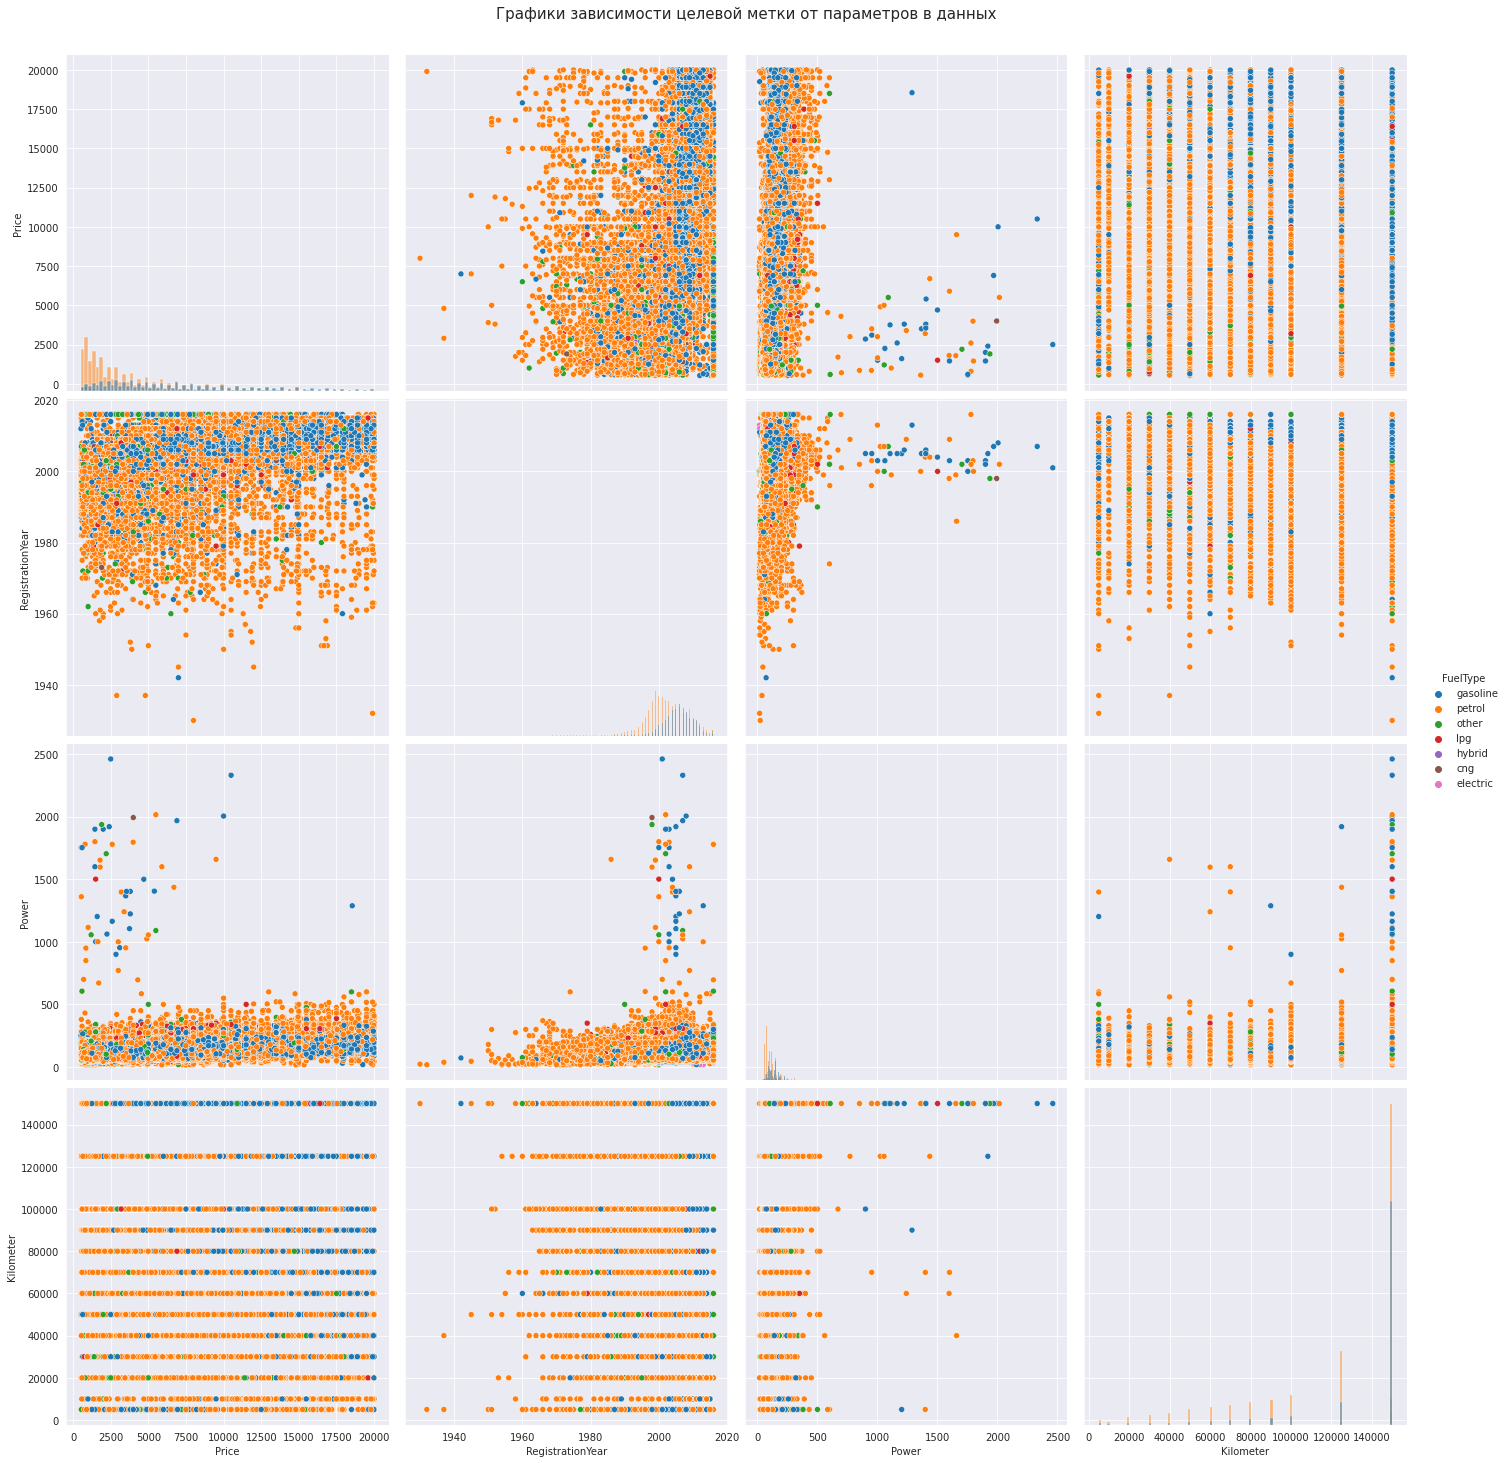

In [66]:
sns.pairplot(data_graph[:100000], hue='FuelType', height=5, diag_kind='hist')
plt.suptitle("Графики зависимости целевой метки от параметров в данных", y=1.02, fontsize=15)
plt.show()

Начиная с 1970 года стоимосоть увеличивается, при этом не важен тип используемого топлива. 
Также из графиков хорошо видно, что альтернативные виды топлива начали активно использоваться в автомобилях начиная с 2000 годов в то время как бензиновые двигателя начали отходить на второй план.

Закодируем текстовые данные в категориальные значения методом OrdinalEncoder.

In [67]:
columns=['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired','GeographyIndex']

In [68]:
data_for_model = data[columns].copy()

In [69]:
data_for_model=data_for_model.reset_index(drop=True)

In [70]:
data_for_model

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,GeographyIndex
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,N/A,9
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,9
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,6
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,3
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,6
...,...,...,...,...,...,...,...,...,...,...,...
238219,5250,N/A,2016,auto,150,159,150000,other,alfa_romeo,no,5
238220,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,9
238221,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,2
238222,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,8


In [71]:
features=data_for_model.drop(['Price'],axis=1)
target=data_for_model['Price']

In [72]:
features.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired', 'GeographyIndex'],
      dtype='object')

Категориальные признаки

In [73]:
num_col=['RegistrationYear', 'Power', 'Kilometer']

In [74]:
results = []

In [75]:
X_train, X_val, y_train, y_val = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [76]:
X_train_2, x_test, y_train_2, y_test = train_test_split(
    features, target, test_size=0.1, random_state=42)

In [77]:
num_features = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()

scaler.fit(X_train[num_features])

StandardScaler()

In [78]:
X_train.loc[:, num_features] = scaler.transform(X_train[num_features])

In [79]:
X_val.loc[:, num_features] = scaler.transform(X_val[num_features])

In [80]:
x_test.loc[:, num_features] = scaler.transform(x_test[num_features])

In [81]:
# функция для кодирования признаков с помощью OneHotEncoder.
def one_hot_transform(df, encoder):
    global cat_features
    trans = ohe.transform(df[cat_features]).toarray()
    df = df.drop(cat_features, axis=1)
    return df

In [82]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Model', 'Brand']

In [83]:
X_train_ohe = X_train.copy()
X_val_ohe = X_val.copy()
X_test_ohe = x_test.copy()

In [84]:
ohe = OneHotEncoder(handle_unknown='ignore', drop='first')
ohe.fit(X_train[cat_features])

OneHotEncoder(drop='first', handle_unknown='ignore')

In [85]:
new_columns=list()
for col, values in zip(cat_features, ohe.categories_):
    new_columns.extend([col + '_' + str(value) for value in values])

In [86]:
new_columns

['VehicleType_N/A',
 'VehicleType_bus',
 'VehicleType_convertible',
 'VehicleType_coupe',
 'VehicleType_other',
 'VehicleType_sedan',
 'VehicleType_small',
 'VehicleType_suv',
 'VehicleType_wagon',
 'Gearbox_auto',
 'Gearbox_manual',
 'FuelType_cng',
 'FuelType_electric',
 'FuelType_gasoline',
 'FuelType_hybrid',
 'FuelType_lpg',
 'FuelType_other',
 'FuelType_petrol',
 'Repaired_N/A',
 'Repaired_no',
 'Repaired_yes',
 'Model_100',
 'Model_145',
 'Model_147',
 'Model_156',
 'Model_159',
 'Model_1_reihe',
 'Model_1er',
 'Model_200',
 'Model_2_reihe',
 'Model_300c',
 'Model_3_reihe',
 'Model_3er',
 'Model_4_reihe',
 'Model_500',
 'Model_5_reihe',
 'Model_5er',
 'Model_601',
 'Model_6_reihe',
 'Model_6er',
 'Model_7er',
 'Model_80',
 'Model_850',
 'Model_90',
 'Model_900',
 'Model_9000',
 'Model_911',
 'Model_a1',
 'Model_a2',
 'Model_a3',
 'Model_a4',
 'Model_a5',
 'Model_a6',
 'Model_a8',
 'Model_a_klasse',
 'Model_accord',
 'Model_agila',
 'Model_alhambra',
 'Model_almera',
 'Model_alte

In [87]:
X_train_ohe = one_hot_transform(X_train, ohe)
X_val_ohe = one_hot_transform(X_val, ohe)
X_test_ohe = one_hot_transform(x_test, ohe)

**Вывод**

- Из данных убраны некорректные значения
- Текстовые признаки трансформированы в цифровой формат
- Выборки разделены на тренировочную и тестовую

Теперь перейдём к обучению моделей и выбору лучшей. Оценим их качество предсказания и скорость обучения.

## Обучение моделей

In [88]:
# функция для оценки и сравнения моделей.
def model_eval(model, X_train, y_train, X_val, y_val, model_type=None):
    
    if not model_type:
        start = time.time()    
        model.fit(X_train, y_train)
        training_time = time.time() - start
        
        start = time.time()  
        y_pred = model.predict(X_val)
        predict_time = time.time() - start
        
    rmse = (mean_squared_error(y_val, y_pred))**0.5
    
    print('Время обучения', np.round(training_time, 6), 'секунд')
    print('Время предсказания', np.round(predict_time, 6), 'секунд')
    print('RMSE', rmse)

    return training_time, predict_time, rmse

In [89]:
linreg = LinearRegression()
res = model_eval(linreg, X_train_ohe, y_train, X_val_ohe, y_val)

Время обучения 0.019215 секунд
Время предсказания 0.16637 секунд
RMSE 3360.010578300103


In [90]:
results = []

In [91]:
results.append(res)

In [92]:
X_train_oe = X_train.copy()
X_val_oe = X_val.copy()
x_test_oe = x_test.copy()

In [93]:
ordincoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
ordincoder.fit(X_train_oe[cat_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=nan)

In [94]:
cat_features

['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Model', 'Brand']

In [95]:
X_train_oe[cat_features] = ordincoder.transform(X_train_oe[cat_features])
X_val_oe[cat_features] = ordincoder.transform(X_val_oe[cat_features])
x_test_oe[cat_features] = ordincoder.transform(x_test_oe[cat_features])

In [96]:
cat = CatBoostRegressor(verbose=100, cat_features=cat_features, random_state=42)

In [97]:
res_2 = model_eval(cat, X_train, y_train, X_val, y_val)

Learning rate set to 0.093849
0:	learn: 4340.4873442	total: 323ms	remaining: 5m 22s
100:	learn: 1718.6111923	total: 17s	remaining: 2m 31s
200:	learn: 1640.8044654	total: 33.3s	remaining: 2m 12s
300:	learn: 1603.4925629	total: 49s	remaining: 1m 53s
400:	learn: 1578.0825728	total: 1m 5s	remaining: 1m 37s
500:	learn: 1559.7826248	total: 1m 21s	remaining: 1m 20s
600:	learn: 1545.1936951	total: 1m 37s	remaining: 1m 4s
700:	learn: 1534.2026636	total: 1m 53s	remaining: 48.2s
800:	learn: 1523.4862749	total: 2m 9s	remaining: 32.2s
900:	learn: 1513.5620940	total: 2m 26s	remaining: 16.1s
999:	learn: 1504.6388705	total: 2m 43s	remaining: 0us
Время обучения 165.531348 секунд
Время предсказания 0.340513 секунд
RMSE 1591.8357031310127


In [98]:
results.append(res_2)

In [106]:
%%time
best_RMSE = 2500
best_depth = 0
best_leaves = 0

for depth in range(10, 14, 2):
    for leaves in range(30, 40):
        lgbregr = lgb.LGBMRegressor(num_leaves = leaves,
                                  max_depth = depth,
                                  random_state=42,
                                  metric='rmse',
                                  learning_rate=0.2,
                                  verbose=-1)
        lgbregr.fit(X_train_oe, y_train)
        predictions_valid = lgbregr.predict(X_val_oe)
        RMSE = mean_squared_error(y_val, predictions_valid)**0.5

        print("RMSE:", RMSE, "Количество листьев:", leaves,  "Глубина дерева:", depth)
        
        if RMSE < best_RMSE:
            best_leaves = leaves
            best_depth = depth
            best_RMSE = RMSE

print('--------')
print("RMSE:", best_RMSE, "Количество листьев:", best_leaves,  "Глубина дерева:", best_depth)

RMSE: 1643.8739503644879 Количество листьев: 30 Глубина дерева: 10
RMSE: 1638.4058931502245 Количество листьев: 31 Глубина дерева: 10
RMSE: 1633.8263181621946 Количество листьев: 32 Глубина дерева: 10
RMSE: 1636.4185983995342 Количество листьев: 33 Глубина дерева: 10
RMSE: 1636.454136613837 Количество листьев: 34 Глубина дерева: 10
RMSE: 1638.3531640677247 Количество листьев: 35 Глубина дерева: 10
RMSE: 1629.3371908118745 Количество листьев: 36 Глубина дерева: 10
RMSE: 1630.5715195764976 Количество листьев: 37 Глубина дерева: 10
RMSE: 1626.0739186564601 Количество листьев: 38 Глубина дерева: 10
RMSE: 1628.8798635208234 Количество листьев: 39 Глубина дерева: 10
RMSE: 1640.052730483458 Количество листьев: 30 Глубина дерева: 12
RMSE: 1638.5681561743345 Количество листьев: 31 Глубина дерева: 12
RMSE: 1633.2916925388229 Количество листьев: 32 Глубина дерева: 12
RMSE: 1634.4757361737702 Количество листьев: 33 Глубина дерева: 12
RMSE: 1631.1253989044442 Количество листьев: 34 Глубина дерева: 

In [107]:
lgbregr = lgb.LGBMRegressor(boosting_type='goss', max_depth=12, num_leaves=39,
              random_state=42)

In [108]:
res_3 = model_eval(lgbregr, X_train_oe, y_train, X_val_oe, y_val)

Время обучения 9.910029 секунд
Время предсказания 0.411119 секунд
RMSE 1661.5936513834804


In [109]:
results.append(res_3)

In [110]:
randfor = RandomForestRegressor(max_depth=26, min_samples_leaf=20, n_estimators=300,
                      random_state=42)

In [111]:
res_4 = model_eval(randfor, X_train_oe, y_train, X_val_oe, y_val)

Время обучения 114.288082 секунд
Время предсказания 2.276963 секунд
RMSE 1729.582916533254


In [112]:
results.append(res_4)

In [113]:
results

[(0.019214630126953125, 0.16637015342712402, 3360.010578300103),
 (165.53134775161743, 0.3405134677886963, 1591.8357031310127),
 (9.91002893447876, 0.4111185073852539, 1661.5936513834804),
 (114.28808236122131, 2.276962995529175, 1729.582916533254)]

## Анализ моделей

In [115]:
def show_res(column, title):
    plt.figure(figsize=(12,6))
    plot = sns.barplot(x=result_table.index, y=result_table[column])
    plt.title(title)
    plt.show()

In [116]:
result_table = pd.DataFrame(data=results,
                            index=['LinearRegression', 'CatBoost', 'LightGBM', 'RandomForest'],
                            columns=['trainig_time', 'prediction_time', 'score'])
result_table

,trainig_time,prediction_time,score
LinearRegression,0.019215,0.166370,3360.010578
CatBoost,165.531348,0.340513,1591.835703
LightGBM,9.910029,0.411119,1661.593651
RandomForest,114.288082,2.276963,1729.582917


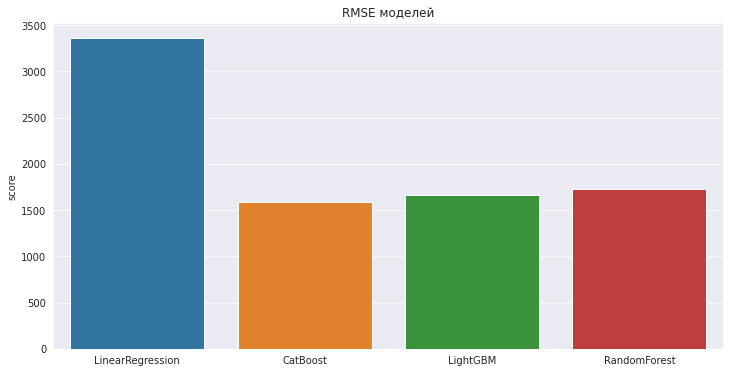

In [117]:
show_res('score', 'RMSE моделей')

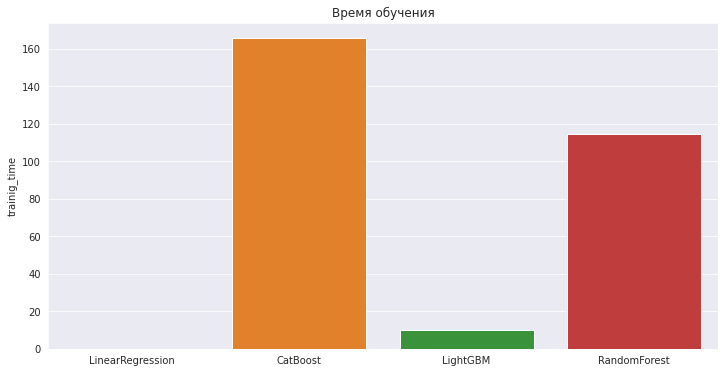

In [118]:
show_res('trainig_time', 'Время обучения')

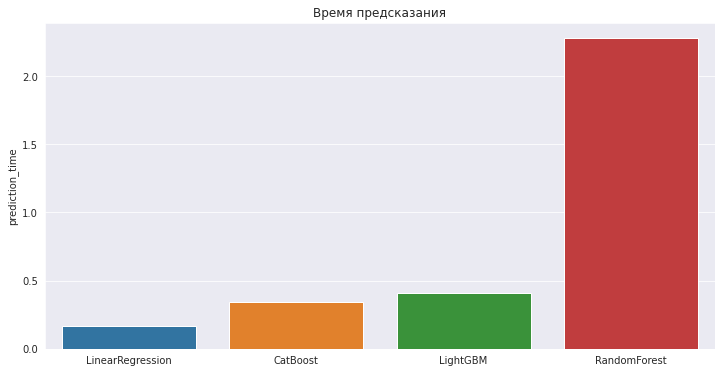

In [119]:
show_res('prediction_time', 'Время предсказания')

**Вывод**

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

Мы видим, что Linear Regression дает худшее качество. 

Модель Random Forest дает достаточно хорошее качество, но обучается очень медленно, эту модель мы отбрасываем. 

Лучшее качество и скорость обучения у модели LightGBM и именно ее нужно рекомендовать в качестве решения.

## Тестирование лучшей модели

In [120]:
X = pd.concat([X_train_oe, X_val_oe])
y = pd.concat([y_train, y_val])

In [123]:
lgbregr.fit(X, y)

LGBMRegressor(boosting_type='goss', max_depth=12, num_leaves=39,
              random_state=42)

In [124]:
pred = lgbregr.predict(x_test_oe)
rmse = (mean_squared_error(y_test, pred))**0.5

In [125]:
print('Финальное качество модели', rmse)

Финальное качество модели 1581.8276555296186


## Вывод

Построили модель для определения стоимости автомобиля, с лучшими показателями качества предсказания, скорости и времени обучения. В нашем распоряжении были данные: технические характеристики, комплектации и цены автомобилей.

Использовали технологию градиетного бустинга в моделях CatBoostRegressor и LGBMRegressor, и сравнили её с базовыми моделями LinearRegression и RandomForestRegressor.

Лучше всего с задачей справилась модель LGBMRegressor.

Таким образом для компании "Не бит, не крашен" можем рекомендовать модель LGBMRegressor.